In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transform
import torch.nn.functional as F
import torchvision.io
from PIL import Image

import matplotlib.pyplot as plt
import numpy as np
import math


In [2]:
def get_data(root):
    data = {}
    for subdir, dirs, files in os.walk(root):
        for file in files:
            path = f"{subdir}/{file}"
            # print(path)
            if ".png" not in path:
                continue
            img = torchvision.io.read_image(path)
            if subdir in data:
                data[subdir].append(img)
            else:
                data[subdir] = [img]

    low_res = torch.stack(data[f'{root}\low_res'])
    low_res = nn.functional.normalize(low_res.float())
    high_res = torch.stack(data[f'{root}\high_res'])
    high_res = nn.functional.normalize(high_res.float())

    t_data = []
    for i in range(len(low_res)):
        temp = (low_res[i], high_res[i])
        t_data.append(temp)

    loader = torch.utils.data.DataLoader(
        t_data, batch_size=20, shuffle=True)

    return loader


In [3]:
train_loader = get_data('dataset/train')
val_loader = get_data('dataset/val')

In [4]:
# class Encoder(nn.Module):
#   def __init__(self):
#     super(Encoder,self).__init__()
#     self.layer1 = nn.Sequential(
#         nn.Conv2d(in_channels=4, out_channels=16,
#                   kernel_size=3, stride=2, padding=1),
#         nn.ReLU())
#     self.layer2 = nn.Sequential(
#         nn.Conv2d(in_channels=16, out_channels=32,
#                   kernel_size=5, stride=2, padding=2),
#         nn.ReLU())
#     self.layer3 = nn.Sequential(
#         nn.Conv2d(in_channels=32, out_channels=64,
#                   kernel_size=7, stride=2, padding=3),
#         nn.ReLU())
#     self.layer4 = nn.Sequential(
#         nn.Conv2d(in_channels=64, out_channels=128,
#                   kernel_size=11, stride=2, padding=5),
#         nn.ReLU())
#     self.f1 = nn.Linear(16*16*128, 196)
#     self.flatten = nn.Flatten(start_dim=1)
#   def forward(self, image):
#     out = self.layer1(image)
#     out = self.layer2(out)
#     out = self.layer3(out)
#     out = self.layer4(out)
#     out = self.flatten(out)
#     out = F.relu(self.f1(out))
#     # out = F.sigmoid(self.f1(out))
#     # out = F.tanh(self.f1(out))
#     return out

# class Decoder(nn.Module):
#   def __init__(self):
#     super(Decoder,self).__init__()
#     self.f3 = nn.Linear(196, 16*16*128)
#     self.unflatten = nn.Unflatten(1, torch.Size([128, 16, 16]))
#     self.layer1 = nn.Sequential(
#         nn.ReLU(),
#         nn.ConvTranspose2d(in_channels=128, out_channels=64,
#                            kernel_size=11, stride=2, padding=5, output_padding=1),
#         )
#     self.layer2 = nn.Sequential(
#         nn.ReLU(),
#         nn.ConvTranspose2d(in_channels=64, out_channels=32,
#                            kernel_size=7, stride=2, padding=3, output_padding=1),
#         )
#     self.layer3 = nn.Sequential(
#         nn.ReLU(),
#         nn.ConvTranspose2d(in_channels=32, out_channels=16,
#                            kernel_size=5, stride=2, padding=2, output_padding=1),
#         )
#     self.layer4 = nn.Sequential(
#         nn.Sigmoid(),
#         nn.ConvTranspose2d(in_channels=16, out_channels=4,
#                            kernel_size=3, stride=2, padding=1, output_padding=1),
#         )

#   def forward(self, z):
#     out = F.relu(self.f3(z))
#     # out = F.sigmoid(self.f3(out))
#     # out = F.tanh(self.f3(out))
#     out = self.unflatten(out) 
#     out = self.layer1(out)
#     out = self.layer2(out)
#     out = self.layer3(out)
#     out = self.layer4(out)
#     return out
 
# class Autoncoder(nn.Module):
#   def __init__(self):
#     super(Autoncoder,self).__init__()
#     self.encoder = Encoder()
#     self.Decoder = Decoder()

#   def forward(self, image):
#     z = self.encoder(image)
#     out =  self.Decoder(z)
#     return out


In [5]:
def joinWithEncoder(fromDec, fromEnc):
    dSize = fromDec.size(2)
    eSize = fromEnc.size(2)

    delta = dSize - eSize
    delta = delta // 2
    left = fromDec[:, :, delta:dSize - delta, delta:dSize - delta]
    return torch.cat([left, fromEnc], dim=1)


In [6]:
class Encoder(nn.Module):
  def __init__(self):
    super(Encoder,self).__init__()
    self.layer1 = nn.Sequential(
        nn.Conv2d(in_channels=4, out_channels=16,
                  kernel_size=3, stride=2, padding=1),
        nn.ReLU())
        #nn.Sigmoid())
        #F.tanh())
    self.layer2 = nn.Sequential(
        nn.Conv2d(in_channels=16, out_channels=32,
                  kernel_size=3, stride=2, padding=1),
        nn.ReLU())
        #nn.Sigmoid())
        #F.tanh())
    self.layer3 = nn.Sequential(
        nn.Conv2d(in_channels=32, out_channels=64,
                  kernel_size=3, stride=2, padding=1),
        nn.ReLU())
        #nn.Sigmoid())
        #F.tanh())
    self.f1 = nn.Linear(32*32*64, 196)
    self.flatten = nn.Flatten(start_dim=1)
  def forward(self, image):
    o1 = self.layer1(image)
    o2 = self.layer2(o1)
    o3 = self.layer3(o2)
    o4 = self.flatten(o3)
    o5 = F.relu(self.f1(o4))
    # out = F.sigmoid(self.f1(out))
    # out = F.tanh(self.f1(out))
    return [o1, o2, o3, o4, o5]

class Decoder(nn.Module):
  def __init__(self):
    super(Decoder,self).__init__()
    self.f1 = nn.Linear(196, 32*32*64)
    self.unflatten = nn.Unflatten(1, torch.Size([64, 32, 32]))
    self.layer1 = nn.Sequential(
        nn.ReLU(),
        #nn.Sigmoid(),
        #F.tanh(),
        nn.ConvTranspose2d(in_channels=128, out_channels=32,
                           kernel_size=3, stride=2, padding=1, output_padding=1),
        )
    self.layer2 = nn.Sequential(
        nn.ReLU(),
        #nn.Sigmoid(),
        #F.tanh(),
        nn.ConvTranspose2d(in_channels=64, out_channels=16,
                           kernel_size=3, stride=2, padding=1, output_padding=1),
        )
    self.layer3 = nn.Sequential(
        nn.Sigmoid(),
        #nn.Sigmoid(),
        #F.tanh(),
        nn.ConvTranspose2d(in_channels=32, out_channels=4,
                           kernel_size=3, stride=2, padding=1, output_padding=1),
        )

  def forward(self, z, dupe=False):
    if not dupe:
      out = F.relu(self.f1(z[-1]))
      # out = F.sigmoid(self.f3(out))
      # out = F.tanh(self.f3(out))
      out = self.unflatten(out) 
      out = self.layer1(joinWithEncoder(out, z[-3]))
      out = self.layer2(joinWithEncoder(out, z[-4]))
      out = self.layer3(joinWithEncoder(out, z[-5]))
    else:
      out = F.relu(self.f1(z))
      # out = F.sigmoid(self.f3(out))
      # out = F.tanh(self.f3(out))
      out = self.unflatten(out)
      out = self.layer1(joinWithEncoder(out, out))
      out = self.layer2(joinWithEncoder(out, out))
      out = self.layer3(joinWithEncoder(out, out))
    return out
 
class Autoncoder(nn.Module):
  def __init__(self):
    super(Autoncoder,self).__init__()
    self.encoder = Encoder()
    self.Decoder = Decoder()

  def forward(self, image):
    z = self.encoder(image)
    out =  self.Decoder(z)
    return out


In [7]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [8]:
def train(model, train_loader, Epochs, loss_fn):
    train_loss_avg = []
    val_loss_avg = []
    for epoch in range(Epochs):
      train_loss_avg.append(0)
      val_loss_avg.append(0)
      num_batches = 0
      val_batches = 0
    
      for low_res, high_res in train_loader:
          low_res = low_res.float().to(device)
          high_res = high_res.float().to(device)

          img_recon = model(low_res)
          # print(img_recon.shape)
          loss = loss_fn(img_recon, high_res)
          
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
          
          train_loss_avg[-1] += loss.item()
          num_batches += 1

      for low_res, high_res in val_loader:
          low_res = low_res.float().to(device)
          high_res = high_res.float().to(device)

          img_recon = model(low_res)
          # print(img_recon.shape)
          loss = loss_fn(img_recon, high_res)

          val_loss_avg[-1] += loss.item()
          val_batches += 1
          
      train_loss_avg[-1] /= num_batches
      val_loss_avg[-1] /= num_batches
      print('Epoch [%d / %d] average reconstruction error: %f' % (epoch+1, Epochs, train_loss_avg[-1]))
    return train_loss_avg, val_loss_avg


In [9]:
def test(model, loss_fn):
    iterator = iter(val_loader)
    test_loss = []
    for i in range(int(len(val_loader)*0.3)):
        low, high = iterator.next()
        low = low.float().to(device)
        high = high.float().to(device)
        img_recon = model(low)
        # print(img_recon.shape)
        loss = loss_fn(img_recon, high)

        test_loss.append(loss.item())
    return print(f"Average loss on test set: {np.mean(test_loss)}")


In [10]:
learning_rate = 0.001
autoencoder = Autoncoder()
autoencoder.to(device)
loss = nn.MSELoss()
optimizer = torch.optim.Adam(params=autoencoder.parameters(), lr=learning_rate, weight_decay=1e-5)
# autoencoder.train()
loss_values, val_loss = train(autoencoder, train_loader,50, loss)
test(model=autoencoder, loss_fn=loss)

Epoch [1 / 50] average reconstruction error: 0.092914
Epoch [2 / 50] average reconstruction error: 0.024576
Epoch [3 / 50] average reconstruction error: 0.018069
Epoch [4 / 50] average reconstruction error: 0.009516
Epoch [5 / 50] average reconstruction error: 0.006175
Epoch [6 / 50] average reconstruction error: 0.004599
Epoch [7 / 50] average reconstruction error: 0.003508
Epoch [8 / 50] average reconstruction error: 0.002880
Epoch [9 / 50] average reconstruction error: 0.002509
Epoch [10 / 50] average reconstruction error: 0.002307
Epoch [11 / 50] average reconstruction error: 0.002140
Epoch [12 / 50] average reconstruction error: 0.002032
Epoch [13 / 50] average reconstruction error: 0.001907
Epoch [14 / 50] average reconstruction error: 0.001815
Epoch [15 / 50] average reconstruction error: 0.001739
Epoch [16 / 50] average reconstruction error: 0.001653
Epoch [17 / 50] average reconstruction error: 0.001586
Epoch [18 / 50] average reconstruction error: 0.001519
Epoch [19 / 50] ave

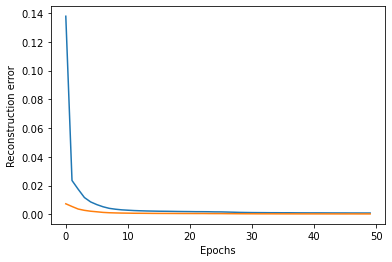

In [22]:
fig = plt.figure()
plt.plot(loss_values)
plt.plot(val_loss)
plt.xlabel('Epochs')
plt.ylabel('Reconstruction error')
plt.show()

In [12]:
with torch.no_grad():
  print("entro")
  iterator = iter(train_loader)
  image, label = iterator.next()
  image = image.float()
  image = image.to(device)
  salida = autoencoder(image)
  tr = torchvision.transforms.ToPILImage()
  tr(image[11]).show()
  tr(label[11]).show()
  tr(salida[11]).show()


entro


In [11]:
def showImage(image):
    tr = torchvision.transforms.ToPILImage()
    tr(image).show()

In [12]:
latent_dims = 196
with torch.no_grad():

  image, label = iter(val_loader).next()
  image = image.to(device)
  z = autoencoder.encoder(image)[-1]
  z = z.to(device)
  mean = z.mean(dim=0)
  mean = mean.to(device)
  std = (z - mean).pow(2).mean(dim=0).sqrt()
  std = std.to(device)
  rnd = torch.randn(10, 196).to(device)
  z1 = rnd*std + mean
  z1 = z1.to(device)
  decodificado = autoencoder.Decoder(z1, True)

  showImage(decodificado[0])
